In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hjb
import hjb_nocost
from matplotlib import animation
from IPython.display import HTML

from scipy.interpolate import interpn
from scipy.integrate import solve_ivp

# Zero-cost control

In [2]:
mx = 100
my = 100
claw = hjb.setup(solver_type='sharpclaw',mx=mx,my=my,min_fac=0.4)
claw.tfinal = 100.
claw.num_output_times = 200
claw.solver.cfl_max=1.49
claw.solver.cfl_desired = 1.48
claw.solver.lim_type=1
claw.solver.call_before_step_each_stage = True
claw.run()

2021-05-16 15:13:11,372 INFO CLAW: Solution 0 computed for time t=0.000000
2021-05-16 15:13:11,451 INFO CLAW: Solution 1 computed for time t=0.500000
2021-05-16 15:13:11,514 INFO CLAW: Solution 2 computed for time t=1.000000
2021-05-16 15:13:11,578 INFO CLAW: Solution 3 computed for time t=1.500000
2021-05-16 15:13:11,643 INFO CLAW: Solution 4 computed for time t=2.000000
2021-05-16 15:13:11,706 INFO CLAW: Solution 5 computed for time t=2.500000
2021-05-16 15:13:11,772 INFO CLAW: Solution 6 computed for time t=3.000000
2021-05-16 15:13:11,837 INFO CLAW: Solution 7 computed for time t=3.500000
2021-05-16 15:13:11,901 INFO CLAW: Solution 8 computed for time t=4.000000
2021-05-16 15:13:11,968 INFO CLAW: Solution 9 computed for time t=4.500000
2021-05-16 15:13:12,038 INFO CLAW: Solution 10 computed for time t=5.000000
2021-05-16 15:13:12,102 INFO CLAW: Solution 11 computed for time t=5.500000
2021-05-16 15:13:12,167 INFO CLAW: Solution 12 computed for time t=6.000000
2021-05-16 15:13:12,23

2021-05-16 15:13:18,406 INFO CLAW: Solution 107 computed for time t=53.500000
2021-05-16 15:13:18,470 INFO CLAW: Solution 108 computed for time t=54.000000
2021-05-16 15:13:18,540 INFO CLAW: Solution 109 computed for time t=54.500000
2021-05-16 15:13:18,605 INFO CLAW: Solution 110 computed for time t=55.000000
2021-05-16 15:13:18,670 INFO CLAW: Solution 111 computed for time t=55.500000
2021-05-16 15:13:18,733 INFO CLAW: Solution 112 computed for time t=56.000000
2021-05-16 15:13:18,799 INFO CLAW: Solution 113 computed for time t=56.500000
2021-05-16 15:13:18,864 INFO CLAW: Solution 114 computed for time t=57.000000
2021-05-16 15:13:18,928 INFO CLAW: Solution 115 computed for time t=57.500000
2021-05-16 15:13:18,993 INFO CLAW: Solution 116 computed for time t=58.000000
2021-05-16 15:13:19,056 INFO CLAW: Solution 117 computed for time t=58.500000
2021-05-16 15:13:19,124 INFO CLAW: Solution 118 computed for time t=59.000000
2021-05-16 15:13:19,187 INFO CLAW: Solution 119 computed for tim

{'cflmax': 1.4800000000000002,
 'dtmin': 0.1258374995748733,
 'dtmax': 0.12583749957487333,
 'numsteps': 801}

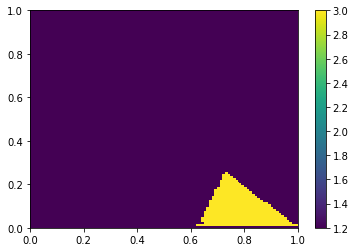

In [3]:
i=20
switch = claw.frames[i].aux[2,:,:]
X,Y = claw.frames[0].grid.p_centers

plt.pcolor(X,Y,switch,shading='auto')
plt.colorbar()

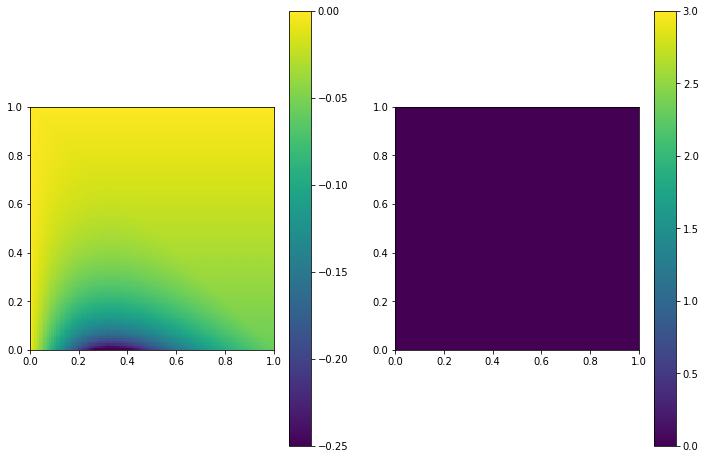

In [4]:
fig, axes = plt.subplots(1,2,figsize=(12,8))
u = claw.frames[0].q[0,:,:]
sigma = claw.frames[0].aux[2,:,:]

pc = axes[0].pcolor(X,Y,u,shading='auto', vmin=-0.25,vmax=0)
#ax.clim(-.4,0)
#ax = plt.gca()
plt.colorbar(pc, ax=axes[0])
axes[0].axis('image')
pcs = axes[1].pcolor(X,Y,sigma,shading='auto', vmin=-0.,vmax=3.)
plt.colorbar(pcs, ax=axes[1])
axes[1].axis('image')

def plot_frame(i):
    u = claw.frames[i].q[0,:,:]
    pc = axes[0].pcolor(X,Y,u,shading='auto',vmin=-0.4,vmax=0)
    sigma = claw.frames[i].aux[2,:,:]
    pc = axes[1].pcolor(X,Y,sigma,shading='auto',vmin=-0.,vmax=3)

In [5]:
anim = animation.FuncAnimation(fig, plot_frame, frames=range(len(claw.frames)))
HTML(anim.to_jshtml())

2021-05-16 15:13:25,596 INFO CLAW: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


KeyboardInterrupt: 

# Foward solve with optimal control

In [6]:
sigmaopt = np.zeros((mx,my,claw.num_output_times+1))
ttt = np.zeros(claw.num_output_times+1)
for i in range(claw.num_output_times+1):
    sigmaopt[:,:,i] = claw.frames[i].aux[2,:,:]
    ttt[i] = claw.frames[i].t

x = claw.grid.x.centers
y = claw.grid.y.centers

In [8]:
T = claw.tfinal
gamma = 0.1
beta = 0.3

def rhs(t, v):
    dv = np.zeros(2)
    if v[1]<np.min(y):
        sigma = 0.
    else:
        sigma = interpn((x.squeeze(),y.squeeze(),ttt.squeeze()),sigmaopt,(v[0],v[1],T-t))

    dv[0] = -sigma*gamma*v[1]*v[0]
    dv[1] =  sigma*gamma*v[1]*v[0] - gamma*v[1]

    return dv

y0 = 0.01 # Initial infected
x0 = 0.99
v0 = np.array((x0,y0))
times = np.arange(0,T)

solution = solve_ivp(rhs,[0,T],v0,t_eval=times,method='RK23',rtol=1.e-3,atol=1.e-3,max_step=5e-2)

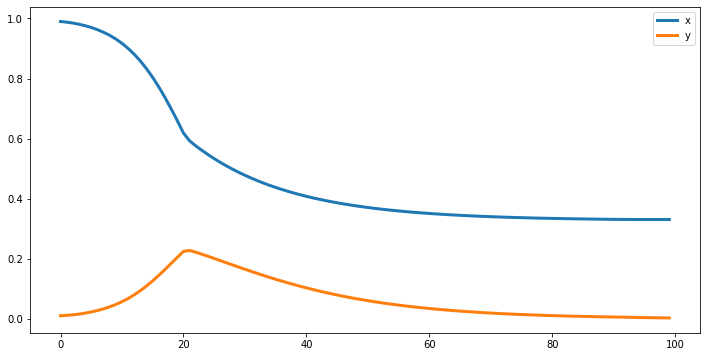

In [9]:
xsol = solution.y[0,:]
ysol = solution.y[1,:]
plt.figure(figsize=(12,6))
plt.plot(times,xsol,lw=3);
plt.plot(times,ysol,lw=3);
plt.legend(['x','y','sigma/sigma0'])

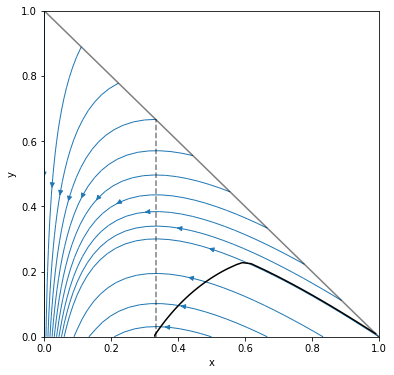

In [10]:
sigma0 = beta/gamma
N1 = 10; N2=5
Y, X = np.mgrid[0:1:100j, 0:1:100j]
U = -beta*X*Y
V = beta*X*Y - gamma*Y
x_points = list(np.linspace(0,1,N1)) + list(np.linspace(1./sigma0,1,N2))
y_points = list(1.-np.linspace(0,1,N1)) + [1.e-6]*N2
seed_points = np.array([x_points, y_points])

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, start_points=seed_points.T,integration_direction='forward',maxlength=1000,
               broken_streamlines=False,linewidth=1)
plt.plot([0,1],[1,0],'-k',alpha=0.5)
plt.plot(xsol,ysol,'-k')
plt.plot([gamma/beta, gamma/beta],[0,1-gamma/beta],'--k',alpha=0.5)
plt.xlim(0,1); plt.ylim(0,1);
plt.xlabel('x'); plt.ylabel('y');

# Control with running cost 

In [6]:
mx = 500
my = 500
c2 = 0.001
claw = hjb.setup(solver_type='sharpclaw',mx=mx,my=my,c2=c2,min_fac=0.)
claw.tfinal = 100.
claw.num_output_times = 200
claw.solver.cfl_max= 1.5
claw.solver.cfl_desired = 1.4
claw.solver.lim_type=1
claw.solver.call_before_step_each_stage = True
claw.run()

2021-05-17 11:20:41,663 INFO CLAW: Solution 0 computed for time t=0.000000
2021-05-17 11:20:43,866 INFO CLAW: Solution 1 computed for time t=0.500000
2021-05-17 11:20:45,783 INFO CLAW: Solution 2 computed for time t=1.000000
2021-05-17 11:20:47,821 INFO CLAW: Solution 3 computed for time t=1.500000
2021-05-17 11:20:49,841 INFO CLAW: Solution 4 computed for time t=2.000000
2021-05-17 11:20:51,972 INFO CLAW: Solution 5 computed for time t=2.500000
2021-05-17 11:20:54,048 INFO CLAW: Solution 6 computed for time t=3.000000
2021-05-17 11:20:55,982 INFO CLAW: Solution 7 computed for time t=3.500000
2021-05-17 11:20:57,999 INFO CLAW: Solution 8 computed for time t=4.000000
2021-05-17 11:21:00,128 INFO CLAW: Solution 9 computed for time t=4.500000
2021-05-17 11:21:02,312 INFO CLAW: Solution 10 computed for time t=5.000000
2021-05-17 11:21:04,385 INFO CLAW: Solution 11 computed for time t=5.500000
2021-05-17 11:21:06,457 INFO CLAW: Solution 12 computed for time t=6.000000
2021-05-17 11:21:08,52

2021-05-17 11:24:19,919 INFO CLAW: Solution 107 computed for time t=53.500000
2021-05-17 11:24:21,927 INFO CLAW: Solution 108 computed for time t=54.000000
2021-05-17 11:24:23,879 INFO CLAW: Solution 109 computed for time t=54.500000
2021-05-17 11:24:25,791 INFO CLAW: Solution 110 computed for time t=55.000000
2021-05-17 11:24:27,712 INFO CLAW: Solution 111 computed for time t=55.500000
2021-05-17 11:24:29,732 INFO CLAW: Solution 112 computed for time t=56.000000
2021-05-17 11:24:31,691 INFO CLAW: Solution 113 computed for time t=56.500000
2021-05-17 11:24:33,646 INFO CLAW: Solution 114 computed for time t=57.000000
2021-05-17 11:24:35,596 INFO CLAW: Solution 115 computed for time t=57.500000
2021-05-17 11:24:37,508 INFO CLAW: Solution 116 computed for time t=58.000000
2021-05-17 11:24:39,425 INFO CLAW: Solution 117 computed for time t=58.500000
2021-05-17 11:24:41,349 INFO CLAW: Solution 118 computed for time t=59.000000
2021-05-17 11:24:43,278 INFO CLAW: Solution 119 computed for tim

{'cflmax': 1.7000000000000004,
 'dtmin': 0.03406813627254508,
 'dtmax': 0.034068136272545096,
 'numsteps': 3000}

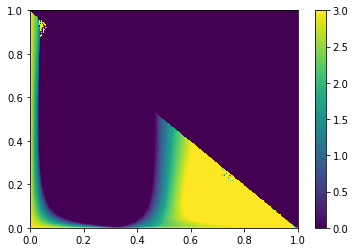

In [7]:
i=20
switch = claw.frames[i].aux[2,:,:]
X,Y = claw.frames[0].grid.p_centers

plt.pcolor(X,Y,switch,shading='auto')
plt.colorbar()

In [8]:
sigmaopt = np.zeros((mx,my,claw.num_output_times+1))
ttt = np.zeros(claw.num_output_times+1)
for i in range(claw.num_output_times+1):
    sigmaopt[:,:,i] = claw.frames[i].aux[2,:,:]
    ttt[i] = claw.frames[i].t
    
x = claw.grid.x.centers
y = claw.grid.y.centers

In [9]:
T = claw.tfinal
gamma = 0.1
beta = 0.3

def rhs(t, v):
    dv = np.zeros(2)
    if v[1]<np.min(y):
        sigma = 0.
    else:
        sigma = interpn((x.squeeze(),y.squeeze(),ttt.squeeze()),sigmaopt,(v[0],v[1],T-t))

    dv[0] = -sigma*gamma*v[1]*v[0]
    dv[1] =  sigma*gamma*v[1]*v[0] - gamma*v[1]

    return dv

y0 = 0.1 # Initial infected
x0 = 0.9
v0 = np.array((x0,y0))
times = np.arange(0,T)

solution = solve_ivp(rhs,[0,T],v0,t_eval=times,method='RK23',rtol=1.e-10,atol=1.e-10,max_step=1e-1)

In [10]:
xsol = solution.y[0,:]
ysol = solution.y[1,:]

sigmastar = np.zeros_like(xsol)
for i in range(len(sigmastar)):
    if ysol[i]<np.min(y[:]):
        sigmastar[i]=0.5
    else:
        sigmastar[i] = interpn((x.squeeze(),y.squeeze(),ttt.squeeze()),sigmaopt,(xsol[i],ysol[i],T-times[i]))

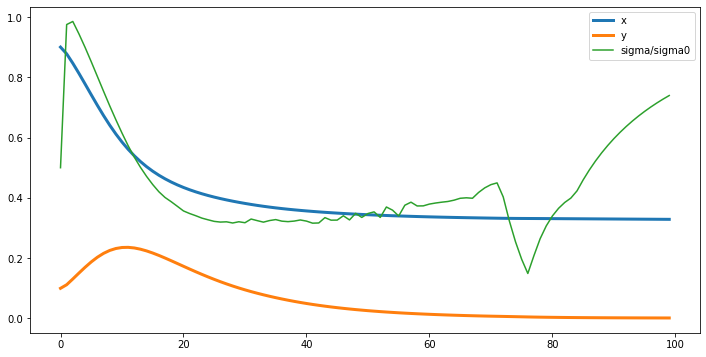

In [11]:
sigma0 = beta/gamma
plt.figure(figsize=(12,6))
plt.plot(times,xsol,lw=3);
plt.plot(times,ysol,lw=3);
plt.plot(times,sigmastar/sigma0)
plt.legend(['x','y','sigma/sigma0'])

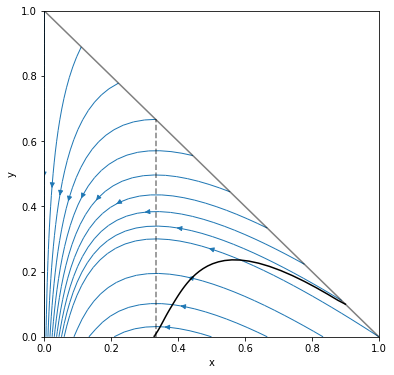

In [12]:
sigma0 = beta/gamma
N1 = 10; N2=5
Y, X = np.mgrid[0:1:100j, 0:1:100j]
U = -beta*X*Y
V = beta*X*Y - gamma*Y
x_points = list(np.linspace(0,1,N1)) + list(np.linspace(1./sigma0,1,N2))
y_points = list(1.-np.linspace(0,1,N1)) + [1.e-6]*N2
seed_points = np.array([x_points, y_points])

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, start_points=seed_points.T,integration_direction='forward',maxlength=1000,
               broken_streamlines=False,linewidth=1)
plt.plot([0,1],[1,0],'-k',alpha=0.5)
plt.plot(xsol,ysol,'-k')
plt.plot([gamma/beta, gamma/beta],[0,1-gamma/beta],'--k',alpha=0.5)
plt.xlim(0,1); plt.ylim(0,1);
plt.xlabel('x'); plt.ylabel('y');

In [13]:
from scipy.special import lambertw, expit

def x_inf(x,y,sigma):
    return -1./sigma * np.real(lambertw(-x*sigma*np.exp(-sigma*(x+y))))

-x_inf(xsol[-1],ysol[-1],sigma0)+(times[1]-times[0])*c2*np.sum((1.-sigmastar/sigma0)**2)

-0.2674088048732502

In [53]:
print(ysol[-1])

0.0030768859126612254


In [41]:
(times[1]-times[0])*c2*np.sum((1.-sigmastar/sigma0)**2)

0.0286460655799099

# Calling top-level function

In [4]:
beta = 0.3
gamma = 0.1
x0 = 0.9
y0 = 0.1
c2 = 0.01
T = 100
x, y, sigma, t = hjb.solve_hjb(beta=beta,gamma=gamma,x0=x0,y0=y0,c2=c2,T=T)

2021-05-17 11:36:04,692 INFO CLAW: Solution 0 computed for time t=0.000000
2021-05-17 11:36:04,973 INFO CLAW: Solution 1 computed for time t=10.000000
2021-05-17 11:36:05,236 INFO CLAW: Solution 2 computed for time t=20.000000
2021-05-17 11:36:05,515 INFO CLAW: Solution 3 computed for time t=30.000000
2021-05-17 11:36:05,778 INFO CLAW: Solution 4 computed for time t=40.000000
2021-05-17 11:36:06,059 INFO CLAW: Solution 5 computed for time t=50.000000
2021-05-17 11:36:06,325 INFO CLAW: Solution 6 computed for time t=60.000000
2021-05-17 11:36:06,593 INFO CLAW: Solution 7 computed for time t=70.000000
2021-05-17 11:36:06,857 INFO CLAW: Solution 8 computed for time t=80.000000
2021-05-17 11:36:07,117 INFO CLAW: Solution 9 computed for time t=90.000000
2021-05-17 11:36:07,376 INFO CLAW: Solution 10 computed for time t=100.000000


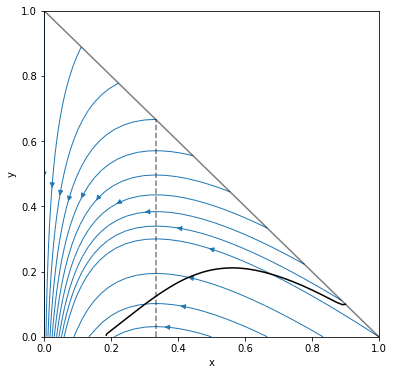

In [5]:
sigma0 = beta/gamma
N1 = 10; N2=5
Y, X = np.mgrid[0:1:100j, 0:1:100j]
U = -beta*X*Y
V = beta*X*Y - gamma*Y
x_points = list(np.linspace(0,1,N1)) + list(np.linspace(1./sigma0,1,N2))
y_points = list(1.-np.linspace(0,1,N1)) + [1.e-6]*N2
seed_points = np.array([x_points, y_points])

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, start_points=seed_points.T,integration_direction='forward',maxlength=1000,
               broken_streamlines=False,linewidth=1)
plt.plot([0,1],[1,0],'-k',alpha=0.5)
plt.plot(x,y,'-k')
plt.plot([gamma/beta, gamma/beta],[0,1-gamma/beta],'--k',alpha=0.5)
plt.xlim(0,1); plt.ylim(0,1);
plt.xlabel('x'); plt.ylabel('y');

In [6]:
beta = 0.3
gamma = 0.1
x0 = 0.9
y0 = 0.1
c2 = 0.001
T = 100
x, y, sigma, t = hjb.solve_hjb(beta=beta,gamma=gamma,x0=x0,y0=y0,c2=c2,T=T)

2021-05-17 11:36:44,798 INFO CLAW: Solution 0 computed for time t=0.000000
2021-05-17 11:36:45,076 INFO CLAW: Solution 1 computed for time t=10.000000
2021-05-17 11:36:45,341 INFO CLAW: Solution 2 computed for time t=20.000000
2021-05-17 11:36:45,650 INFO CLAW: Solution 3 computed for time t=30.000000
2021-05-17 11:36:45,948 INFO CLAW: Solution 4 computed for time t=40.000000
2021-05-17 11:36:46,214 INFO CLAW: Solution 5 computed for time t=50.000000
2021-05-17 11:36:46,492 INFO CLAW: Solution 6 computed for time t=60.000000
2021-05-17 11:36:46,763 INFO CLAW: Solution 7 computed for time t=70.000000
2021-05-17 11:36:47,051 INFO CLAW: Solution 8 computed for time t=80.000000
2021-05-17 11:36:47,339 INFO CLAW: Solution 9 computed for time t=90.000000
2021-05-17 11:36:47,649 INFO CLAW: Solution 10 computed for time t=100.000000


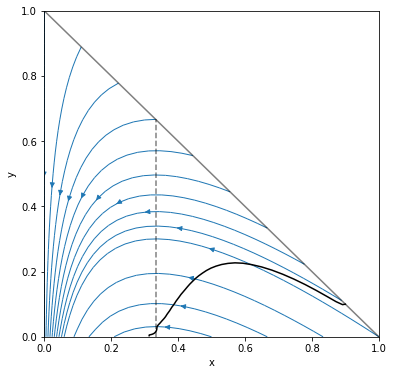

In [7]:
sigma0 = beta/gamma
N1 = 10; N2=5
Y, X = np.mgrid[0:1:100j, 0:1:100j]
U = -beta*X*Y
V = beta*X*Y - gamma*Y
x_points = list(np.linspace(0,1,N1)) + list(np.linspace(1./sigma0,1,N2))
y_points = list(1.-np.linspace(0,1,N1)) + [1.e-6]*N2
seed_points = np.array([x_points, y_points])

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, start_points=seed_points.T,integration_direction='forward',maxlength=1000,
               broken_streamlines=False,linewidth=1)
plt.plot([0,1],[1,0],'-k',alpha=0.5)
plt.plot(x,y,'-k')
plt.plot([gamma/beta, gamma/beta],[0,1-gamma/beta],'--k',alpha=0.5)
plt.xlim(0,1); plt.ylim(0,1);
plt.xlabel('x'); plt.ylabel('y');

In [13]:
beta = 0.3
gamma = 0.1
x0 = 0.9
y0 = 0.1
c2 = 0.00001
T = 100
mx = 500
my = 500
x, y, sigma, t = hjb.solve_hjb(beta=beta,gamma=gamma,x0=x0,y0=y0,c2=c2,T=T,mx=mx,my=my)

2021-05-17 11:39:18,423 INFO CLAW: Solution 0 computed for time t=0.000000
2021-05-17 11:39:50,911 INFO CLAW: Solution 1 computed for time t=10.000000
2021-05-17 11:40:21,794 INFO CLAW: Solution 2 computed for time t=20.000000
2021-05-17 11:40:52,761 INFO CLAW: Solution 3 computed for time t=30.000000
2021-05-17 11:41:26,558 INFO CLAW: Solution 4 computed for time t=40.000000
2021-05-17 11:42:02,526 INFO CLAW: Solution 5 computed for time t=50.000000
2021-05-17 11:42:37,854 INFO CLAW: Solution 6 computed for time t=60.000000
2021-05-17 11:43:13,706 INFO CLAW: Solution 7 computed for time t=70.000000
2021-05-17 11:43:49,283 INFO CLAW: Solution 8 computed for time t=80.000000
2021-05-17 11:44:25,391 INFO CLAW: Solution 9 computed for time t=90.000000
2021-05-17 11:45:00,722 INFO CLAW: Solution 10 computed for time t=100.000000


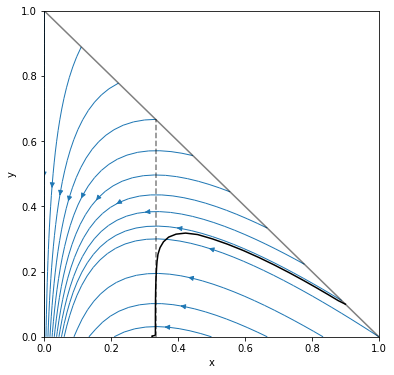

In [12]:
sigma0 = beta/gamma
N1 = 10; N2=5
Y, X = np.mgrid[0:1:100j, 0:1:100j]
U = -beta*X*Y
V = beta*X*Y - gamma*Y
x_points = list(np.linspace(0,1,N1)) + list(np.linspace(1./sigma0,1,N2))
y_points = list(1.-np.linspace(0,1,N1)) + [1.e-6]*N2
seed_points = np.array([x_points, y_points])

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, start_points=seed_points.T,integration_direction='forward',maxlength=1000,
               broken_streamlines=False,linewidth=1)
plt.plot([0,1],[1,0],'-k',alpha=0.5)
plt.plot(x,y,'-k')
plt.plot([gamma/beta, gamma/beta],[0,1-gamma/beta],'--k',alpha=0.5)
plt.xlim(0,1); plt.ylim(0,1);
plt.xlabel('x'); plt.ylabel('y');